In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import cv2 as cv
import open3d
import numpy as np

from utils.io_utils import get_matching_pairs, get_images, get_depths
from utils.calib_utils import detect_keypoints, undistort_intrinsics, to_homogeneous, to_cartesian, undistort_images, transform2local, plane2plane_transformation, undistort_depths, to_norm_image_coord, compose_fund_mat, optimize_pose_lm, pointcloudify_depths
from utils.vis_utils import plot_figures, plot_projected_keypoints, plot_projected_pcd, to_open3d, plot_epipolar_lines, draw_chessboard_corners, normalize_image


### Load data

In [9]:
img_ext = '.png'
depth_ext = '.npy'

In [10]:
# Data paths
s10_images_path = "/home/konstantin/datasets/bandeja-sequence/2021-02-23-21-18-22/smartphone_video_frames"
azure_images_path = "/home/konstantin/datasets/bandeja-sequence/2021-02-23-21-18-22/_azure_ir_image_raw"
azure_depths_path = "/home/konstantin/datasets/bandeja-sequence/2021-02-23-21-18-22/_azure_depth_image_raw"

In [11]:
# Deterime matching pairs between s10 and azure either by matching or providing the list of timestamps manually
s10_timestamps, azure_timestamps = get_matching_pairs(s10_images_path, azure_images_path)

In [12]:
s10_images = get_images(s10_images_path, period=65, file_name_list=[fn + img_ext for fn in s10_timestamps])

In [13]:
azure_images = get_images(azure_images_path, period=65, file_name_list=[fn + img_ext for fn in azure_timestamps])
azure_depths = get_depths(azure_depths_path, period=65, file_name_list=[fn + depth_ext for fn in azure_timestamps])

In [14]:
# Load intrinsics cailbration results which should include intrinsics, distortion coefficients and undistorted intrinsics
s10_intrinsics_calib = np.load('calib_output/s10_intrinsics.npy', allow_pickle=True).item()

s10_intrinsics = s10_intrinsics_calib['intrinsics']
s10_dist_coeff = s10_intrinsics_calib['dist_coeff']
s10_undist_intrinsics = s10_intrinsics_calib['undist_intrinsics']

In [15]:
# Stock calibration for azure
azure_intrinsics = np.array([[503.9581604003906, 0.0, 325.4591064453125],
                             [0.0, 504.0079345703125, 340.33404541015625],
                             [0.0, 0.0, 1.0]])

azure_dist_coeff = np.array([5.268435478210449, 3.5621509552001953, -6.14773682627856e-07, -4.438921678229235e-05, 0.1832902431488037, 5.597447872161865, 5.32110071182251, 0.9697896838188171])

azure_undist_intrinsics = undistort_intrinsics(azure_images, azure_intrinsics, azure_dist_coeff)

In [16]:
# Undistort all data before the work
s10_images = undistort_images(s10_images, s10_intrinsics, s10_dist_coeff, s10_undist_intrinsics)
azure_images = undistort_images(azure_images, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics)

In [17]:
azure_depths = undistort_depths(azure_depths, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics)

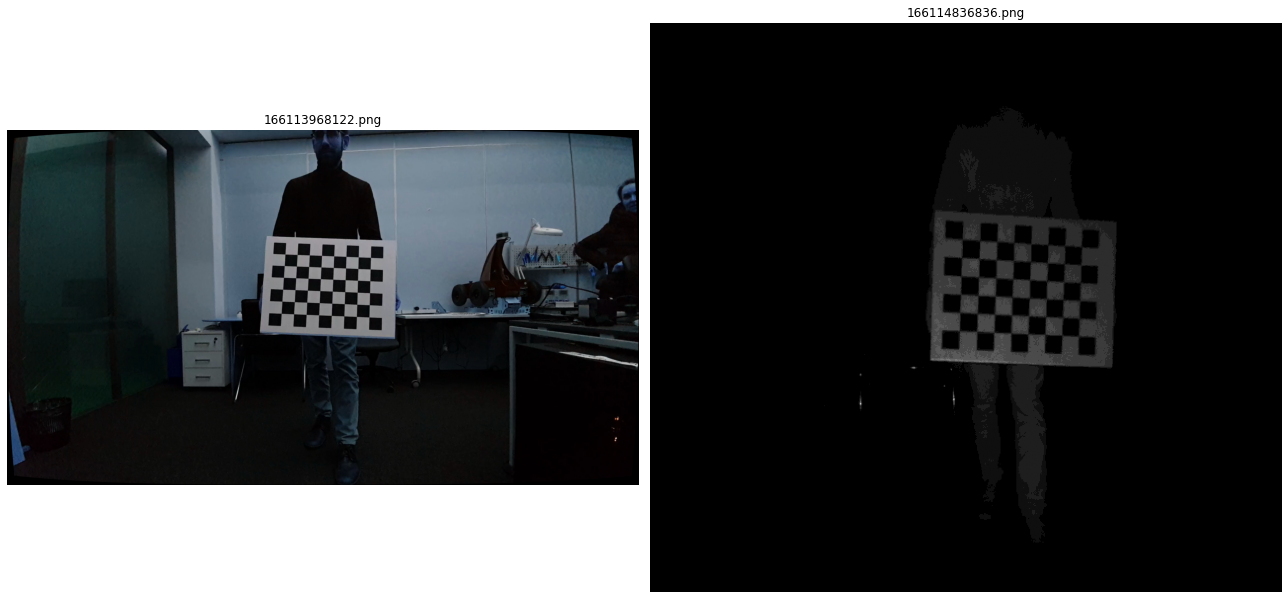

In [18]:
idx = 0

check_s10_key, check_azure_key = s10_timestamps[idx], azure_timestamps[idx]

plot_figures({check_s10_key + img_ext: s10_images[check_s10_key + img_ext], 
              check_azure_key + img_ext: normalize_image(azure_images[check_azure_key + img_ext])}, 1, 2)

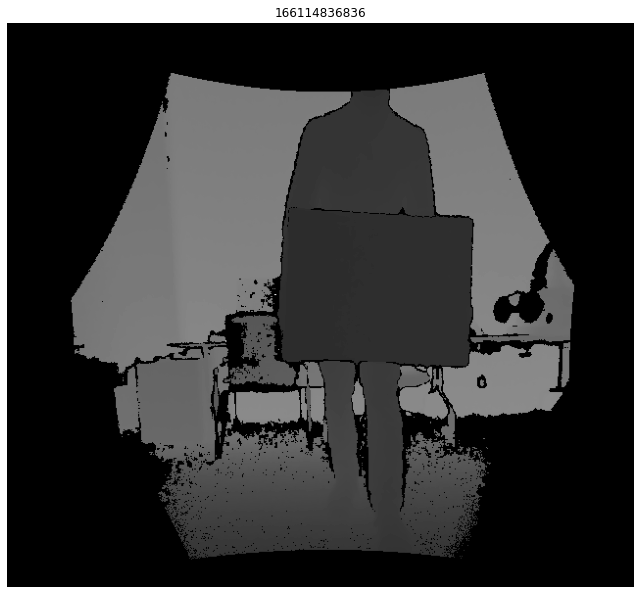

In [19]:
check_azure_depth = azure_depths[check_azure_key + depth_ext]

plot_figures({check_azure_key: check_azure_depth}, size=(9, 9))

### Detect keypoints

In [20]:
pattern_size = (8, 6)
edge_length = 0.05

In [21]:
# Detect keypoint
s10_detections = detect_keypoints(s10_images, pattern_size, edge_length)
azure_detections = detect_keypoints(azure_images, pattern_size, edge_length)

In [22]:
# Leave only those  pairs that have detections on both images
s10_det_mask = np.array([t + img_ext in s10_detections for t in s10_timestamps])
azure_det_mask = np.array([t + img_ext in azure_detections for t in azure_timestamps])

det_mask = s10_det_mask & azure_det_mask

d_s10_timestamps, d_azure_timestamps = s10_timestamps[det_mask], azure_timestamps[det_mask]

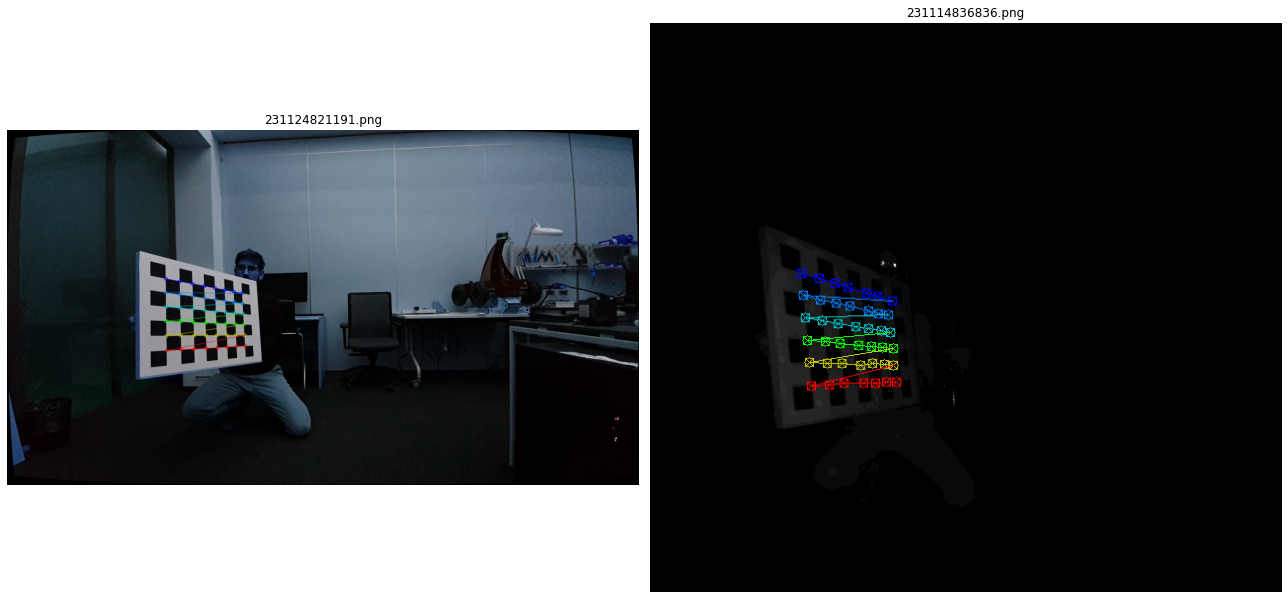

In [24]:
# Detections on azure may be innacurate so take this into account when optimizing the solutions

idx = 5

check_s10_key, check_azure_key = d_s10_timestamps[idx] + img_ext, d_azure_timestamps[idx] + img_ext


plot_figures({check_s10_key: draw_chessboard_corners(s10_images[check_s10_key], 
                                                     s10_detections[check_s10_key][1], 
                                                     pattern_size),
              check_azure_key: draw_chessboard_corners(azure_images[check_azure_key], 
                                                       azure_detections[check_azure_key][1], 
                                                       pattern_size, normalize=True)}, 1, 2)

### s10-to-chessboard transformation

In [25]:
# Solve PnP for find transformation between s10 keypoints and points on the board

s10_chess = {}

for ts in d_s10_timestamps:
    scene_points, loc_kp = s10_detections[ts + img_ext]
    success, r, t = cv.solvePnP(scene_points, loc_kp, s10_undist_intrinsics, None, flags=cv.SOLVEPNP_IPPE)
    
    if success:
        dS = np.zeros((4, 4))
        dS[:3, :3] = cv.Rodrigues(r)[0]
        dS[:3, 3] = np.reshape(t, -1)
        dS[3, 3] = 1
        
        s10_local_scene_points = to_cartesian((dS @ to_homogeneous(scene_points).transpose()).transpose())
        
        s10_chess[ts] = s10_local_scene_points


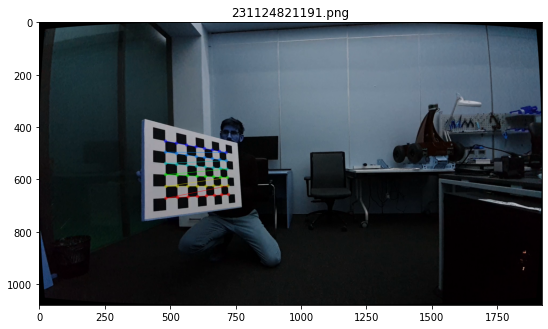

In [26]:
# Visualize transformed scene points with the estimated by PnP transformation to make sure the solution make sense
idx = 5

check_key = d_s10_timestamps[idx] + img_ext

plot_projected_keypoints(s10_images[check_key], s10_chess[check_key.split('.')[0]], s10_undist_intrinsics, check_key, pattern_size)

### azure-to-chessboard transformation

In [27]:
# Take keypoints from azure and use depth to create a point cloud out of them

azure_chess = {}

for t in d_azure_timestamps:
    loc_kp = np.squeeze(azure_detections[t + img_ext][1], 1)
    depth = azure_depths[t + depth_ext]
    
    norm_loc_kp = to_norm_image_coord(loc_kp, azure_undist_intrinsics)
    
    azure_local_loc_kp = transform2local(loc_kp, norm_loc_kp, depth)
    
    azure_chess[t] = azure_local_loc_kp

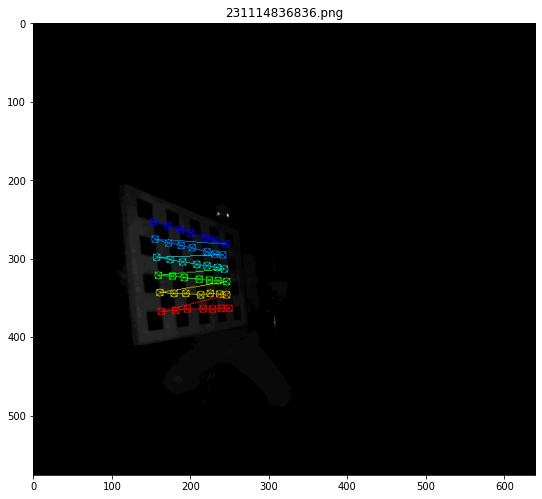

In [28]:
# Agian perform the check to make sure that obtained points are reasonable
idx = 5

check_key = d_azure_timestamps[idx] + img_ext

plot_projected_keypoints(azure_images[check_key], azure_chess[check_key.split('.')[0]], azure_undist_intrinsics, check_key, pattern_size, normalize=True)

In [29]:
# Visualize two chessboards next to each other and get the avg. error between corresponding points

idx = 0

check_azure_chess, check_s10_chess = azure_chess[d_azure_timestamps[idx]], s10_chess[d_s10_timestamps[idx]]

open3d.visualization.draw_geometries([to_open3d(check_azure_chess), to_open3d(check_s10_chess)])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [30]:
np.linalg.norm(check_s10_chess - check_azure_chess, axis=-1).mean()

0.2307998886316105

### azure-s10-extrinsics guess

In [31]:
# Estimate the point-to-point transformation between two pointclouds

extrinsics = {}

for t_s10, t_azure in zip(d_s10_timestamps, d_azure_timestamps):
    
    s10_ch = s10_chess[t_s10]
    azure_ch = azure_chess[t_azure]
    
    extrinsics[t_s10 + ' ' + t_azure] = plane2plane_transformation(azure_ch, s10_ch)


In [32]:
# Get estimated transformation and check:
idx = 5

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_azure_chess, check_s10_chess = azure_chess[check_azure_key], s10_chess[check_s10_key]

check_T = extrinsics[check_s10_key + ' ' + check_azure_key]

In [33]:
# 1) avg. error between points
check_t_azure_chess = to_cartesian((check_T @ to_homogeneous(check_azure_chess).transpose()).transpose())

np.linalg.norm(check_t_azure_chess - check_s10_chess, axis=-1).mean()

0.10358534229452636

In [34]:
# 2) by examining the solution visually
open3d.visualization.draw_geometries([to_open3d(check_t_azure_chess), to_open3d(check_s10_chess)])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


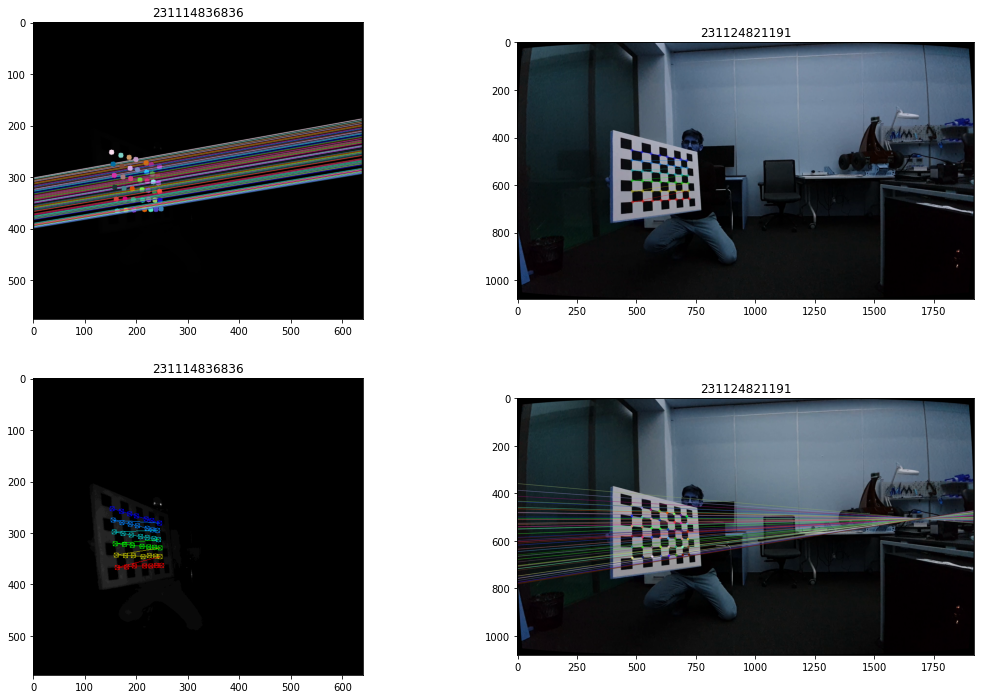

In [35]:
# 3) by plotting epipolar lines 

check_F = compose_fund_mat(check_T, azure_undist_intrinsics, s10_undist_intrinsics)

plot_epipolar_lines(azure_images[check_azure_key + img_ext], s10_images[check_s10_key + img_ext], 
                    azure_detections[check_azure_key + img_ext][1], s10_detections[check_s10_key + img_ext][1],
                    check_azure_key, check_s10_key, check_F, pattern_size)

In [36]:
# The initial solution as can be seen from epipolar lines is highly inaccurate thus we need to further 
# minimize avg. epipolar distance

opt_extrinsics = {}

for i, (key, Ti) in enumerate(extrinsics.items()):
    s10_t, azure_t = key.split(' ')
    
    print('Index: ', i)
    
    s10_loc_kp, azure_loc_kp = s10_detections[s10_t + img_ext][1], azure_detections[azure_t + img_ext][1]
    Ti_opt = optimize_pose_lm(Ti, np.squeeze(azure_loc_kp), np.squeeze(s10_loc_kp), azure_undist_intrinsics, s10_undist_intrinsics)
    
    opt_extrinsics[key] = Ti_opt


Index:  0
Avg. epipolar distance:  1.958880784003977
Index:  1
Avg. epipolar distance:  14.4251334939441
Index:  2
Avg. epipolar distance:  12.567994903428312
Index:  3
Avg. epipolar distance:  779.1395536096686
Index:  4
Avg. epipolar distance:  4.102563695613498
Index:  5
Avg. epipolar distance:  47.60915831787847
Index:  6
Avg. epipolar distance:  514.2724510555437
Index:  7
Avg. epipolar distance:  3.1840140939507195
Index:  8
Avg. epipolar distance:  10.511812879237908
Index:  9
Avg. epipolar distance:  1.2592235220331833


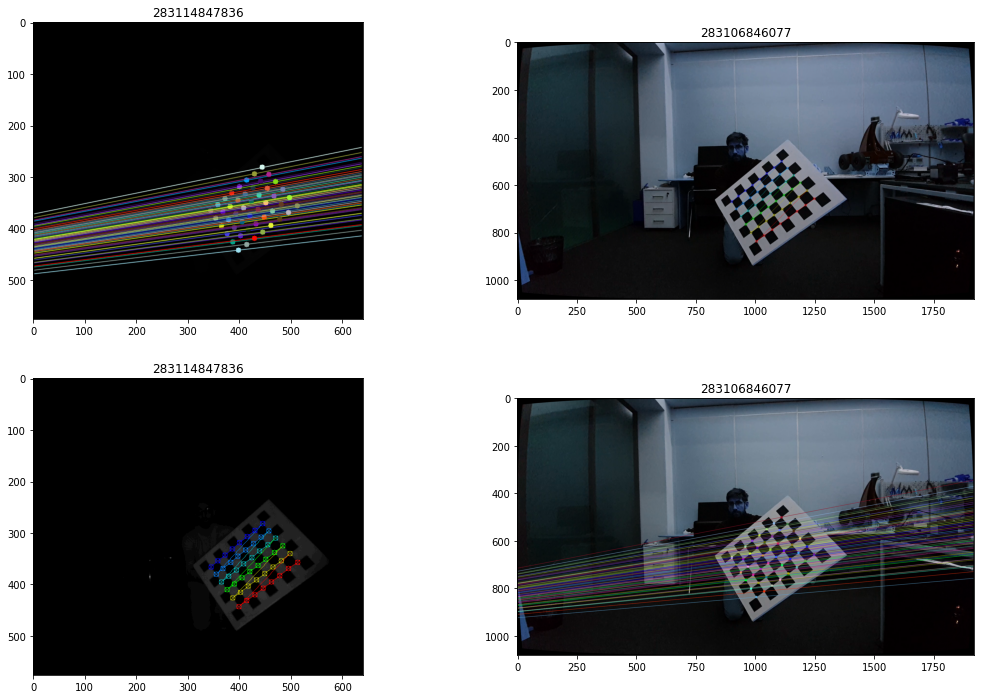

In [37]:
# Examine the solution after the optimization. Lines should be close to their corresponding points 
idx = 9

check_key = list(opt_extrinsics.keys())[idx]
check_T_opt = opt_extrinsics[check_key]

check_s10_key, check_azure_key = check_key.split(' ')

check_F = compose_fund_mat(check_T_opt, azure_undist_intrinsics, s10_undist_intrinsics)

plot_epipolar_lines(azure_images[check_azure_key + '.png'], s10_images[check_s10_key + '.png'],
                    azure_detections[check_azure_key + '.png'][1], s10_detections[check_s10_key + '.png'][1], 
                    check_azure_key, check_s10_key, check_F, pattern_size)


### Visualize transformed keypoints, depth and tune the solution

In [38]:
tuned_extrinsics = {}

In [39]:
# Transform all depth measurements to a point cloud
azure_pcd_depths = pointcloudify_depths(azure_depths, azure_undist_intrinsics)

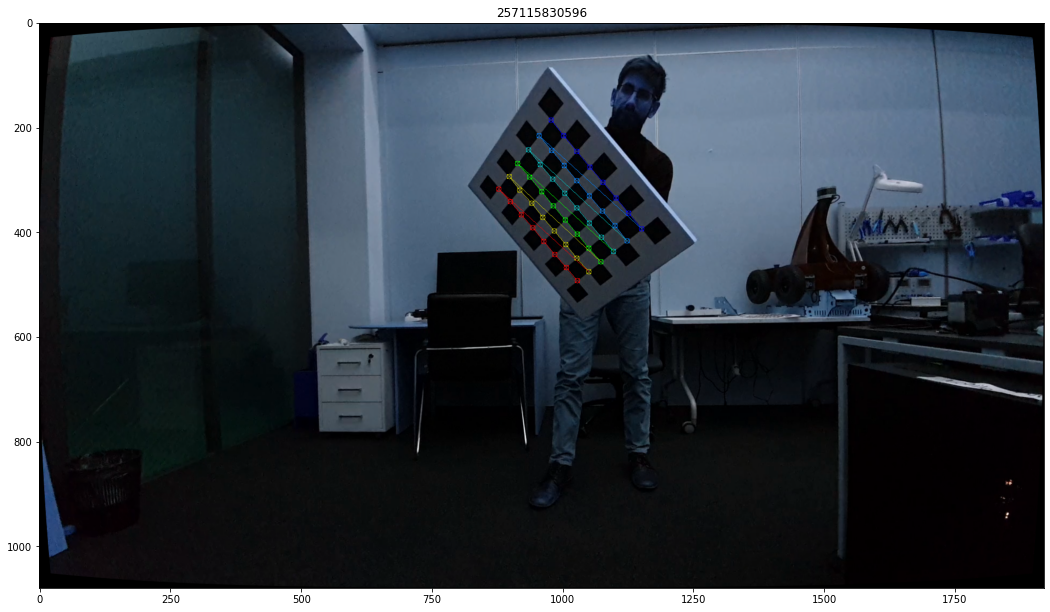

In [71]:
T_idx = 9

key_opt = list(opt_extrinsics.keys())[T_idx]
T_opt = opt_extrinsics[key_opt]

# As F is known up to a scale factor the exact magnitude of the translation is unknown and 
# it has to be tuned manually by changing the factor below

T_tuned = np.copy(T_opt)
T_tuned[:3, 3] = -0.323 * T_tuned[:3, 3]

# Keypoints should be well aligned with their respective locations on multiple images

idx = 7

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_azure_chess = to_cartesian((T_tuned @ to_homogeneous(azure_chess[check_azure_key]).transpose()).transpose())

plot_projected_keypoints(s10_images[check_s10_key + img_ext], check_azure_chess, 
                         s10_undist_intrinsics, check_s10_key, pattern_size, fig_size=(18, 18), normalize=True)


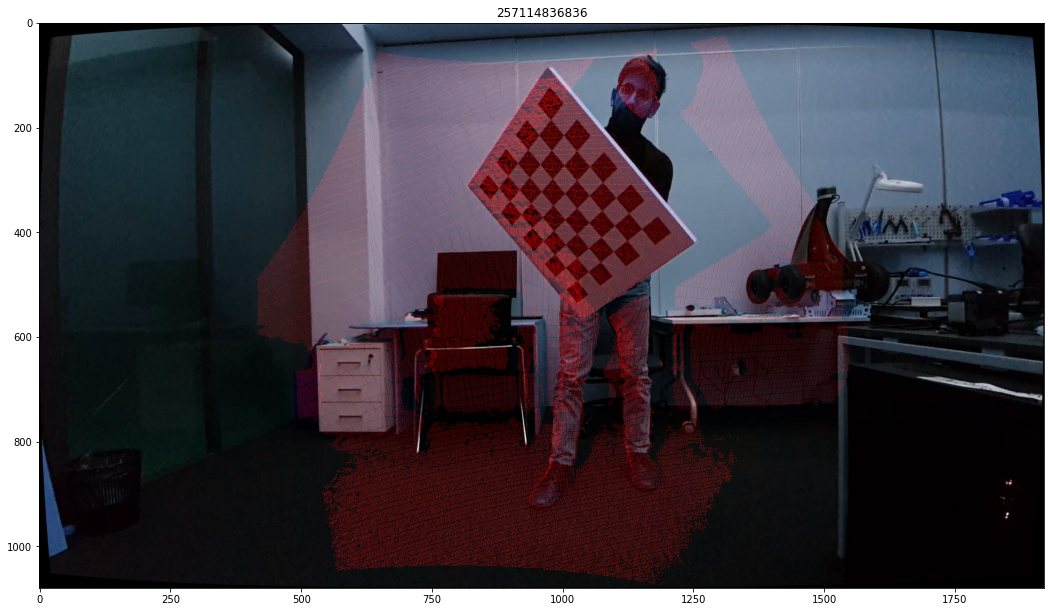

In [72]:
# Transform pointcloudified depth from azure to s10 system of coordinates and visualize it as a final check

check_azure_pcd = azure_pcd_depths[check_azure_key + depth_ext]
check_azure_pcd = to_cartesian((T_tuned @ to_homogeneous(check_azure_pcd).transpose()).transpose())

plot_projected_pcd(s10_images[check_s10_key + img_ext], check_azure_pcd, s10_undist_intrinsics, check_azure_key)

In [73]:
T_tuned

array([[ 0.99729899, -0.00502003,  0.07327708, -0.23595893],
       [-0.00230789,  0.99502716,  0.0995772 ,  0.04474221],
       [-0.07341256, -0.09947735,  0.992328  ,  0.06272296],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [74]:
# Save tuned transformation
tuned_extrinsics[key_opt] = T_tuned

In [75]:
tuned_extrinsics

{'283106846077 283114847836': array([[ 0.99729899, -0.00502003,  0.07327708, -0.23595893],
        [-0.00230789,  0.99502716,  0.0995772 ,  0.04474221],
        [-0.07341256, -0.09947735,  0.992328  ,  0.06272296],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [76]:
np.save('calib_output/tuned_extrinsics', tuned_extrinsics)